# k-均值聚类
优点：实现容易

缺点：可能收敛到局部最小值，在大规模数据集上收敛较慢

k-均值聚类是无监督学习的算法，没有训练过程。主要思想是在数据集中随机生成K个簇质心，然后根据每个点和质心之间的距离远近情况，将该点聚类到离他最近的那个质心所属与的那一类;一直迭代，直到任何点的簇不再发生改变为止。


In [1]:
from numpy import *

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))#create centroid mat
    for j in range(n):#create random cluster centers, within bounds of each dimension
        minJ = min(dataSet[:,j]) 
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = mat(minJ + rangeJ * random.rand(k,1))
    return centroids

In [2]:
#测试一下
fineName = '/home/wl/文档/machinelearninginaction/Ch10/testSet.txt'
dataMat = mat(loadDataSet(fineName))
dataMat = array(dataMat)
dataMat[:5]

array([[ 1.658985,  4.285136],
       [-3.453687,  3.424321],
       [ 4.838138, -1.151539],
       [-5.379713, -3.362104],
       [ 0.972564,  2.924086]])

In [3]:
randCent(dataMat,2)

matrix([[-0.34049577,  2.77217441],
        [-1.135311  , -3.2239427 ]])

In [4]:
distEclud(dataMat[0],dataMat[1])

5.184632816681332

In [5]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))#create mat to assign data points 
                                      #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#将数据集中每个点和K个质心点依次求距离
            minDist = inf; minIndex = -1 #初始最小距离为无穷大，初始每一个点不属于每一类
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:]) #计算第 i 个点和第 j 个质心的距离
                if distJI < minDist:
                    minDist = distJI; minIndex = j #将第 i 个点与其距离最小的质心聚类在一起
            if clusterAssment[i,0] != minIndex: clusterChanged = True #如果第 i 点的聚类结果还在改变，则再次循环迭代，直到聚类结果不再改变
            clusterAssment[i,:] = minIndex,minDist**2 #[a ,b]，a存储该点所聚类的点名称，b存储它们之间的距离平方
        print (centroids)
        for cent in range(k):#recalculate centroids更新质心的位置
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]#nonzero()返回数组中不为0值的元素的下标
            centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean 将和同一个质心聚类在一起的点，按列计算平均值，一一赋值给质心坐标相应的位置，得到质心坐标
    return centroids, clusterAssment

In [6]:
myCenttroids, clustAssing = kMeans(dataMat, 4)
#将‘testSet.txt'文件中的数据按4个类别进行聚类，经过3次迭代后k-均值算法收敛。

[[-0.5580457  -2.57796158]
 [-5.0091961   3.28317935]
 [ 4.74910455  0.72387864]
 [-3.46121528 -0.79597091]]
[[ 1.29373229 -3.15359267]
 [-2.54183917  2.93204467]
 [ 2.95373358  2.32801413]
 [-3.56434918 -2.23997653]]
[[ 2.44502437 -2.980011  ]
 [-2.46154315  2.78737555]
 [ 2.80642645  2.73635527]
 [-3.53973889 -2.89384326]]
[[ 2.65077367 -2.79019029]
 [-2.46154315  2.78737555]
 [ 2.6265299   3.10868015]
 [-3.53973889 -2.89384326]]


# 使用后处理来提高聚类性能
k-均值聚类中，k是用户事先确定好的参数，那么如何知道k的取值是否正确呢？在包含族分诶结果的矩阵clusterAssment中保存折每个点的误差，即该点到簇质心的距离平方和。可以利用误差来评价聚类效果。

使用SSE（误差平方和）来度量聚类效果。，SSE越小表示数据点越接近于它们的质心，聚类效果也越好。

* 将具有最大SSE值的簇划分为两个簇，为保持簇总数不变，可以将两个簇进行合并
* 合并最近的质心
* 合并两个使得SSE增幅最小的质心

# 二分K-均值算法
克服K-均值算法收敛与局部最小值的问题。

将所有点堪称一个簇

当簇小于k时：

对每一个簇：

    计算总误差
    
    在给定的簇上面进行K均值聚类（k=2）
    
    计算将该簇一分为二之后的总误差
    
选择使得总误差最小的那个簇进行划分操作

In [9]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]
    #创建矩阵保存簇分配结果和平方误差
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    #得到第一个质心，初始簇
    centList =[centroid0] #create a list with one centroid
    for j in range(m):#calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        #遍历每一个簇
        for i in range(len(centList)):
            #clusterAssment[:,0].A==i：取矩阵的第一列转换乘Array数组，取簇编号为 i 的所有点
            #clusterAssment[:,0].A==i：得到一个布尔数组
            #nonzeros(a)返回数组a中值不为零的元素的下标
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]#get the data points currently in cluster i
            #将一个簇分成2个簇，保存结果
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])#计算各点平方误差之和compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print ("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        print ('the bestCentToSplit is: ',bestCentToSplit)
        print ('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]#replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE
    return mat(centList), clusterAssment

In [10]:
#测试一下
fineName = '/home/wl/文档/machinelearninginaction/Ch10/testSet2.txt'
dataMat3 = mat(loadDataSet(fineName))
dataMat3 = array(dataMat3) #dataMat3是一个对象地址，需要使用list 或者array来提取其中的数据
dataMat3[:5]

array([[ 3.275154,  2.957587],
       [-3.344465,  2.603513],
       [ 0.355083, -3.376585],
       [ 1.852435,  3.547351],
       [-2.078973,  2.552013]])

In [11]:
centList, myNewAssments = biKmeans(dataMat3,3)

[[-0.46255493  2.58639106]
 [ 4.03341805  2.79613222]]
[[-1.48868947  0.49011019]
 [ 3.20884012  3.08500406]]
[[-1.70351595  0.27408125]
 [ 2.93386365  3.12782785]]
sseSplit, and notSplit:  541.297629265 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  60
[[-2.88762098  0.47228938]
 [-1.94340499 -3.85675394]]
[[-2.79578405  2.92664291]
 [-0.36852161 -2.96793856]]
[[-2.94737575  3.3263781 ]
 [-0.45965615 -2.7782156 ]]
sseSplit, and notSplit:  67.2202000798 39.5292986821
[[ 3.38701994  1.51624213]
 [ 2.87594555  2.95765727]]
[[ 3.3570382   1.8464974 ]
 [ 2.79280547  3.554938  ]]
[[ 3.1604785   1.93671333]
 [ 2.836743    3.6383055 ]]
sseSplit, and notSplit:  26.9283722645 501.768330583
the bestCentToSplit is:  0
the len of bestClustAss is:  40


In [34]:
centList

matrix([[-2.94737575,  3.3263781 ],
        [ 2.93386365,  3.12782785],
        [-0.45965615, -2.7782156 ]])

In [14]:
myNewAssments[:5]

matrix([[ 1.        ,  0.14546105],
        [ 0.        ,  0.68021383],
        [ 2.        ,  1.02184582],
        [ 1.        ,  1.3454876 ],
        [ 0.        ,  1.35376464]])

In [43]:
def plotBestFit(dataArr,centList,clusterAssment):
    """绘制聚类结果示意图"""
    import matplotlib.pyplot as plt
    lenData = len(clusterAssment)
    clusterAssment = array(clusterAssment)
    xcord0 = []; ycord0 = []
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
    for i in range(lenData): #区分n类标签的点，将其表示为不同颜色的散点图
        if int(clusterAssment[i][0])== 0:
            xcord0.append(dataArr[i,0]); ycord0.append(dataArr[i,1])
        elif int(clusterAssment[i][0])== 1:
            xcord1.append(dataArr[i,0]); ycord1.append(dataArr[i,1])
        else:
            xcord2.append(dataArr[i,0]); ycord2.append(dataArr[i,1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord0, ycord0, s=30, c='red', marker='s')
    ax.scatter(xcord1, ycord1, s=30, c='green')
    ax.scatter(xcord2, ycord2, s=30, c='brown')
    for i in range(3):
        plt.plot(centList[i,0], centList[i,1],'*')
    plt.show()

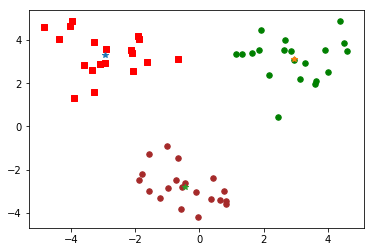

In [44]:
plotBestFit(dataMat3,centList,myNewAssments)

# 对地图上的点进行聚类